In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd
from legwork import utils, strain, psd, source
from astropy.coordinates import SkyCoord
#from CV_pop import sample_porb_from_Knigge_2011
import scipy.stats as stats
from astropy.coordinates import get_body_barycentric
from astropy.time import Time


In [3]:

max_distance = 500 # parsecs: must be larger than 150!
!python3 CV_pop.py --max-distance {max_distance} --mu-m1 0.7 --sigma-m1 0.001 --sigma-m2 0.001


We need 54 sources within 150pc. Generating new population!
We have 62 sources
We're good! More than 54 sources in 150pc sample. Deleting some sources.


In [4]:
filename = f"dat_maxDistance_{max_distance}.txt"
dat = pd.read_csv(filename)



In [5]:
dat = dat.rename(columns={'# m1[Msun]':'m1',
                          ' m2[Msun]':'m2',
                          ' inclination[rad]':'inc',
                          ' f_gw[Hz]':'f_gw',
                          ' x_gal[kpc]':'x', 
                          ' y_gal[kpc]':'y', 
                          ' z_gal[kpc]':'z',
                          ' Pala_reassigned' : 'pala'})


In [6]:
KT = pd.read_csv('kniggeTable.csv')
PT = pd.read_hdf('Pala_2020_dat_combo.h5')

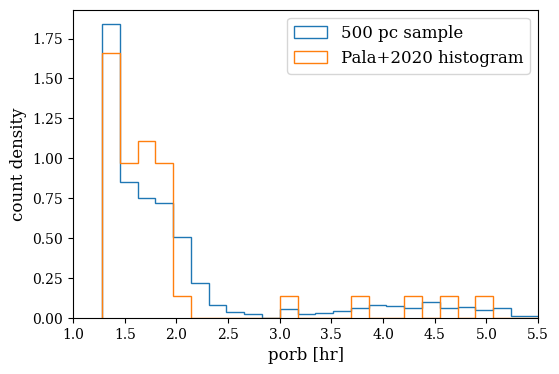

In [7]:
plt.figure(figsize=(6, 4))
plt.hist(1/(dat.f_gw/2) / 3600, bins=50, density=True, histtype='step', label=f'{max_distance} pc sample')
#plt.hist(KT.Per, density=True, bins=50, histtype='step', label='Knigge+2011 histogram')
plt.hist(PT.porb/60, density=True, histtype='step', bins=50, label='Pala+2020 histogram')
plt.xlabel('porb [hr]', size=12)
plt.ylabel('count density', size=12)
plt.legend(prop={'size':12})
plt.tick_params('both', labelsize=10)
plt.xlim(1, 5.5)
plt.savefig("porb.png")


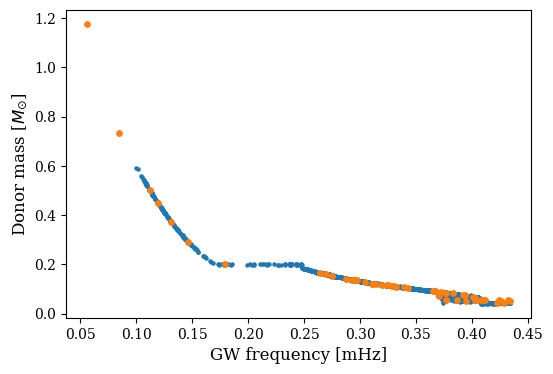

In [8]:
fig = plt.figure(figsize=(6, 4))
plt.scatter(dat['f_gw']*1000, dat['m2'], s=5)
plt.scatter(dat.loc[dat.pala > 0].f_gw*1000, dat.loc[dat.pala > 0].m2, s=15)
plt.xlabel('GW frequency [mHz]', size=12)
plt.ylabel('Donor mass [$M_{\odot}$]', size=12)
plt.tick_params('both', labelsize=10)


In [9]:
c = SkyCoord(dat.x, dat.y, dat.z, unit=u.kpc, frame='galactocentric')

dist = c.icrs.distance

mc = utils.chirp_mass(dat['m1'].values * u.Msun, dat['m2'].values * u.Msun)

In [10]:
sources = source.Source(m_1=dat['m1'].values * u.Msun, m_2=dat['m2'].values * u.Msun, 
                        ecc=np.zeros_like(dat['m1'].values), dist=dist, f_orb=dat['f_gw'].values/2 * u.Hz,
                        interpolate_g=False)

In [11]:
snr = sources.get_snr()
ASD = strain.h_0_n(m_c=mc, f_orb=dat['f_gw'].values/2 * u.Hz,  
                   ecc=np.zeros(len(mc)), dist=dist, 
                   n=2, position=None, polarisation=None, 
                   inclination=None, interpolated_g=None) * np.sqrt(4 * 3.155e7)
    

The space density within 150 pc is: 3.819718634205488e-06
Total number of sources: 1119
Total volume: 392699081.69872415
Recovered space density: 2.8495101011172943e-06
0.03804056519403334 kpc
[4.1667067  4.47190199]
217    98.260012
620    81.630001
Name: f_gw, dtype: float64


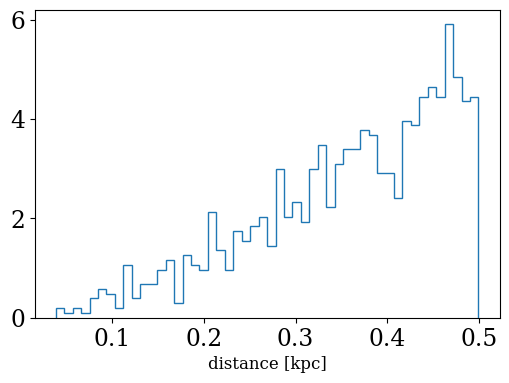

In [15]:
ind, = np.where(dat.pala == 1)
indD, = np.where(dat.pala==2)

c = SkyCoord(dat.x, dat.y, dat.z, unit=u.kpc, frame='galactocentric', representation_type='cartesian')
d = c.transform_to('barycentrictrueecliptic')
d_rounded = np.around(d.distance, decimals=5)

indCheck150, = np.where(d_rounded <= 0.15*u.kpc)

n150 = len(indCheck150)
V150 = 4/3 * np.pi * 150**3
print(f"The space density within 150 pc is: {n150/V150}")

# Sanity check: what is the space density of the sample? Should be just under 4.8e-6 N/pc^3
Nsources = d.shape[0] # total number of sources in the sample
Vol = np.pi*max_distance**3 # total volume of the sample in pc^3
print("Total number of sources:",Nsources)
print("Total volume:", Vol)
print('Recovered space density:', Nsources/Vol)

# Another check is to plot the distribution of sources in the z direction

print(d.distance.min())
plt.figure(figsize=(6, 4))
plt.hist((np.array(d.distance)), bins=50, density=True, histtype='step', label='800 pc sample')
plt.xlabel('distance [kpc]', size=12)

frequency_range = frequency_range=np.logspace(-5, 0, 1000) * u.Hz
LISA = psd.lisa_psd(frequency_range, approximate_R=False, confusion_noise='robson19')


# Print orbital periods of S/N>4 sources.
palaSNR = snr[ind]
indH = np.where(palaSNR > 4)
#print(palaSNR)
print(palaSNR[indH])    
print(1/(dat.f_gw[ind[indH]]/2) / 60)


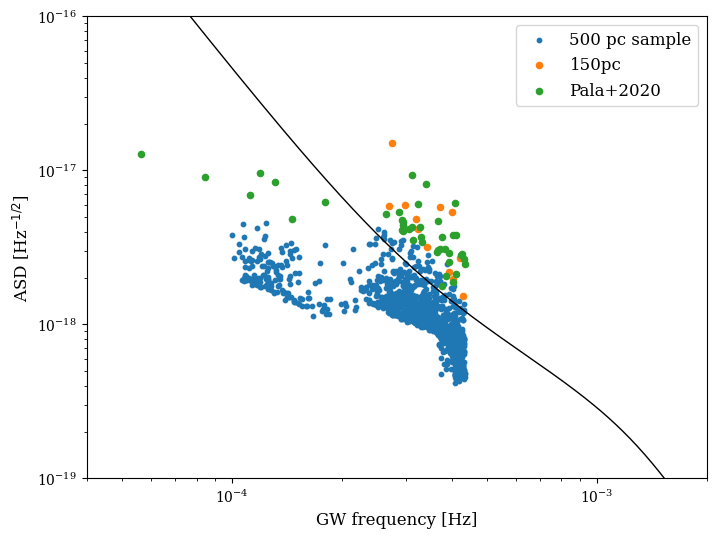

In [16]:
fig = plt.figure(figsize=(8, 6))


plt.plot(frequency_range, LISA**0.5, lw=1, c='black')   
plt.scatter(dat.f_gw, ASD, s=10, label=f'{max_distance} pc sample')
#plt.scatter(dat.f_gw[indD], ASD[indD], s=10, label='150 pc sample')
plt.scatter(dat.loc[dat.pala == 2].f_gw, ASD[indD], s=20, label='150pc')
plt.scatter(dat.loc[dat.pala == 1].f_gw, ASD[ind], s=20, label='Pala+2020')
plt.legend(prop={'size':12})
plt.yscale('log')
plt.xscale('log')
plt.xlim(4e-5, 2e-3)
plt.ylim(1e-19, 1e-16)
plt.xlabel('GW frequency [Hz]', size=12)
plt.ylabel('ASD [Hz$^{-1/2}$]', size=12)
plt.tick_params('both', labelsize=10)

plt.savefig("asd.png")